<a href="https://colab.research.google.com/github/cjpdrury/evidence_networks/blob/main/evidence_network_optuna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Evidence Network example

In [ ]:
# install this version of tf to use decayed lr metric
!pip install tensorflow==2.8.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.6/497.6 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 102.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.5/462.5 kB 49.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 86.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 99.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 64.0 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.1
    Uninstalling tensorboard-data-server-0.7.1:
      Successfully uninstalled tensorboard-data-server-0.7.1
  Attempting uninstall: google-auth-oauthlib
    Found existing inst

In [ ]:
!pip install optuna
!pip install optuna.integration


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 11.0 MB/s eta 0:00:00


In [ ]:

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Jul 10 09:42:44 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import numpy as np
from scipy.stats import norm, multivariate_normal
import sys, os, time, gc

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LeakyReLU, Input,ReLU
from tensorflow.keras import optimizers, callbacks

from tensorflow.keras.layers import concatenate, BatchNormalization

import pandas as pd
import random
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import optuna
from optuna.integration import TFKerasPruningCallback

import requests
import time


import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams['image.cmap'] = 'coolwarm'
print(tf.config.list_physical_devices('GPU'))
tf.print(tf.constant([0.0]))
print(tf.__version__)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[0]
2.8.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# !cd /content/drive/MyDrive/ML_Intern/

path = '/content/drive/MyDrive/ML_Intern'



Mounted at /content/drive


## Import Data and Save as Numpy file
Once Numpy file is created it is not necessary to run this

In [ ]:
# import and save data as npy file
train_Illu = np.loadtxt(path+"/galaxies_IllustrisTNG_z=0.00.txt", float)
train_SIMB = np.loadtxt(path+"/galaxies_SIMBA_z=0.00.txt", float)

f = open(path+"/galaxies_IllustrisTNG_z=0.00.txt")
header = f.readline()

np.save(path+'/gal_Illu.npy',train_Illu)
np.save(path+'/gal_SIMB.npy',train_SIMB)


In [ ]:
f = open(path+"/galaxies_IllustrisTNG_z=0.00.txt")
header = f.readline()
header = header.split('|')
print(header[0:10])
# gal_Illu

['# ', ' gas mass ', ' stellar mass ', ' black-hole mass ', ' total mass ', ' Vmax ', ' velocity dispersion ', ' gas metallicity ', ' stars metallicity ', ' star-formation rate ']


## Load and prepare data
Each data file contains >100,000 data vectors. Note that SIMBA is about a 1.6x larger dataset than IllustrisTNG. A data vector is a package of 17 properties for a given galaxy. The values are normalised as they range over several orders of magnitude. A dataframe for each model is made to examine the data, but the numpy array is fed into the network as this is faster. <br>
The models are assigned the labels; SIMBA (1), IllustrisTNG (0). They are combined into one set of training data. x_train is the data and y_train is the labels.


In [ ]:
# unpack data
train_Illu = np.load(path+'/gal_Illu.npy')
train_SIMB = np.load(path+'/gal_SIMB.npy')
print(np.shape(train_Illu))

# get headers and convert to pandas
header = 'gas mass | stellar mass | black-hole mass | total mass | Vmax | velocity dispersion | gas metallicity | stars metallicity | star-formation rate | spin | peculiar velocity | stellar radius | total radius | Vmax radius | U | K | g'
header = header.split('|')

df_Illu = pd.DataFrame(train_Illu, columns=header)
df_SIMB = pd.DataFrame(train_SIMB, columns=header)

# add model labels 'm'
df_Illu['m'] = np.zeros(df_Illu.shape[0])
df_SIMB['m'] = np.ones(df_SIMB.shape[0])



(720548, 17)


In [ ]:
df_gal = df_Illu.append(df_SIMB)
df_gal.head()
# df_gal.iloc[0:5,0:5]

<ipython-input-7-bbc7c8626d90>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gal = df_Illu.append(df_SIMB)


,gas mass,stellar mass,black-hole mass,total mass,Vmax,velocity dispersion,gas metallicity,stars metallicity,star-formation rate,spin,peculiar velocity,stellar radius,total radius,Vmax radius,U,K,g,m
0,9.282650e+12,5.420345e+11,1.466206e+09,6.418189e+13,728.5484,388.82180,0.004787,0.017947,9.441491,7318.4480,33.48256,0.021288,0.265175,0.195745,-22.93387,-26.54785,-23.42693,0.0
1,1.038497e+11,2.636133e+10,1.044907e+07,9.836553e+11,233.9234,119.81900,0.018286,0.015760,2.637218,1866.9370,514.23650,0.005122,0.044712,0.015302,-21.15315,-23.88854,-21.25109,0.0
2,9.195971e+08,2.106634e+10,1.157354e+08,3.509456e+11,208.0617,99.18353,0.009185,0.015279,0.000000,129.6710,469.85760,0.003984,0.025255,0.004423,-19.08513,-23.24341,-19.95050,0.0
3,3.779673e+10,1.197717e+09,1.650660e+06,2.944225e+11,155.9398,88.05768,0.002823,0.003315,0.186221,1364.7460,903.87620,0.007515,0.026186,0.027755,-18.45237,-20.64906,-18.61216,0.0
4,6.460591e+09,9.020908e+09,3.054039e+06,1.818515e+11,150.3801,76.50587,0.016340,0.010027,0.260545,115.4676,318.39040,0.005950,0.019798,0.007311,-19.32953,-22.77941,-19.95593,0.0


In [ ]:
# assign label of 0 for IllustrisTNG and 1 for SIMBA
train_Illu = np.append(train_Illu, np.zeros((len(train_Illu[:,0]),1)) ,axis=1)
train_SIMB = np.append(train_SIMB, np.ones((len(train_SIMB[:,0]),1)) ,axis=1)



In [ ]:
# combine into one dataset
train_data = np.append(train_SIMB,train_Illu, axis=0 )


# below is for using stellar mass and stellar metallicity
train_data = train_data[:,[1,7,-1]]

print(train_data[:,:-1].shape)


(1902813, 2)


In the following we select a sub-sample of the data to speed up training. The dataset is then split into training and testing in an 80:20 split.


In [ ]:
# randomly sample from training data

n_sample = 500000
# n_sample = train_data.shape[0]

choices = np.random.choice(train_data.shape[0],
                                  size=n_sample,
                                  replace=False)
train_data = train_data[choices,:]
print(train_data.shape)


# separate training, validation and test data
x_train, x_test, y_train, y_test = train_test_split(train_data[:,:-1], train_data[:,-1], test_size=0.20, shuffle=True, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train[:,:], y_train[:], test_size=0.20, shuffle=True, random_state=41)


(500000, 3)


In [ ]:
print(x_train.shape, x_val.shape, x_test.shape, y_train.shape, y_val.shape,y_test.shape )

(320000, 2) (80000, 2) (100000, 2) (320000,) (80000,) (100000,)


In [ ]:
# check the fraction of each model is the same in each set
print(np.mean(y_train), np.mean(y_val),np.mean(y_test) )

0.62301875 0.6199875 0.62231


## Scale data and view distributions

In [ ]:
# normalise each set of data:- note this is specific to stellar mass and metallicity

x_train_scaled = np.copy(x_train)
x_train_scaled[:,0] = np.log(x_train_scaled[:,0])
scaler = StandardScaler()
scaler.fit(x_train_scaled)
x_train_scaled = scaler.transform(x_train_scaled)/20.+0.5

def data_scaler(data):
    """
    Scales input testing and validation data
    """

    data_scaled = np.copy(data)
    data_scaled[:,0] = np.log(data[:,0])
    data_scaled = scaler.transform(data_scaled)/20.+0.5

    return data_scaled

x_test_scaled = data_scaler(x_test)
x_val_scaled = data_scaler(x_val)


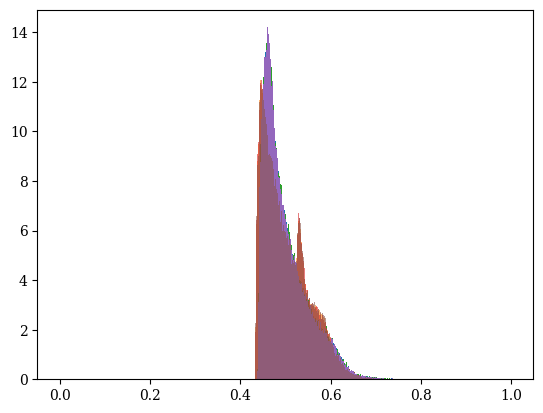

In [ ]:
# check distributions match
_ = plt.hist(x_train_scaled[:,1],bins=np.linspace(-0,1,512),density=True)
_ = plt.hist(x_train_scaled[:,0],bins=np.linspace(-0,1,512),alpha=0.6,density=True)

_ = plt.hist(x_val_scaled[:,1],bins=np.linspace(-0,1,512),density=True)
_ = plt.hist(x_val_scaled[:,0],bins=np.linspace(-0,1,512),alpha=0.6,density=True)

_ = plt.hist(x_test_scaled[:,1],bins=np.linspace(-0,1,512),density=True)
_ = plt.hist(x_test_scaled[:,0],bins=np.linspace(-0,1,512),alpha=0.6,density=True)

In [ ]:
# view distributions of all data

# plt.figure(figsize=(10,18))
# for i in range(17):
#     plt.subplot(6,3,i+1)
#     plt.grid(False)
#     _ = plt.hist(x_train_scaled[:,i],bins=np.linspace(-5,5,512),density=True)
#     plt.title(str(header[i]))

# plt.subplots_adjust(hspace=.2)


This cell finds the ratio of samples from each model.

In [ ]:
scale = np.sum(y_train)/np.sum(1 - y_train)

print('Current prior model ratio (model 1/model 0): ',
      scale,
      flush=True)




Current prior model ratio (model 1/model 0):  1.6526518228691744


## Define functions for network

In [ ]:
def smooth_sign(x, k =100.):

    return 2.*tf.math.sigmoid(k*x) - 1


def parity_odd_power(x, alpha=2):
    return (x)*(tf.math.abs(x)**(alpha-1))


# def leaky_parity_odd_power(x, alpha=2):
#     x_transition = (alpha)**(alpha/(1.-alpha))
#     shift=(alpha)**(1./(1.-alpha)) - x_transition
#     return tf.where(tf.math.abs(x)<x_transition, x, tf.sign(x)*tf.math.abs(x+tf.sign(x)*shift)**alpha)


def leaky_parity_odd_power(x, alpha=2):
    return x + parity_odd_power(x, alpha)

In [ ]:
# Evidence Net functions:

class POPExpLoss(tf.keras.losses.Loss):
    """
    Custom exponential loss
    """

    def call(self, model_label, model_pred):
        model_pred =  leaky_parity_odd_power(model_pred, alpha=1)
        model_pred = tf.clip_by_value(model_pred, -50, 50)
        loss_val =  tf.math.exp((0.5 - model_label) * (model_pred) )
        return tf.reduce_mean(loss_val)


class ExpLoss(tf.keras.losses.Loss):
    """
    Custom exponential loss
    """

    def call(self, model_label, model_pred):
        model_pred = tf.clip_by_value(model_pred, -50, 50)
        loss_val =  tf.math.exp((0.5 - model_label) * (model_pred) )
        return tf.reduce_mean(loss_val)


def get_lr_metric(optimizer):
    """
    Learning rate on-the-fly
    :param optimizer:
    :return: learning rate
    """
    def lr(y_true, y_pred):
        return optimizer._decayed_lr(tf.float32)  # I use ._decayed_lr method instead of .lr
        # return optimizer.lr(tf.float32) #C try .lr
    return lr



class DenseNetwork:
    """
    Network that takes in data and returns functions of the Bayesian evidence
    """

    def __init__(self, input_size, weight_init='he_normal', layer_width=100, added_layers=3,
                 learning_rate=1e-4, decay_rate=None, batch_norm_flag=1, residual_flag=0):
        """
        Initialisation
        :param map_size: size of square image (there are map_size**2 pixels)
        :param learning_rate: learning rate for the optimizer
        """
        self.input_size = input_size
        self.learning_rate = learning_rate
        self.layer_width = layer_width
        self.weight_init = weight_init
        self.decay_rate = decay_rate
        self.added_layers = added_layers
        self.batch_norm_flag = batch_norm_flag
        self.residual_flag = residual_flag


        print('Hyper-parameters:', input_size, weight_init, layer_width, added_layers,
              learning_rate, decay_rate, batch_norm_flag, residual_flag)

    def simple_layer(self, x_in):
        x_out = Dense(self.layer_width, kernel_initializer=self.weight_init)(x_in)
        x_out = LeakyReLU(alpha=0.1)(x_out)
        # x_out = tf.tanh(x_out)
        if self.batch_norm_flag == 1:
            x_out = BatchNormalization()(x_out)
        return x_out

    def residual_block(self, x_in):
        x_out = Dense(self.layer_width, kernel_initializer=self.weight_init)(x_in)
        x_out = LeakyReLU(alpha=0.1)(x_out)
        # x_out = tf.tanh(x_out)
        if self.batch_norm_flag == 1:
            x_out = BatchNormalization()(x_out)

        x_out = Dense(self.layer_width, kernel_initializer=self.weight_init)(x_out)
        x_out = LeakyReLU(alpha=0.1)(x_out) + x_in
        if self.batch_norm_flag == 1:
            x_out = BatchNormalization()(x_out)

        return x_out

    def model(self):

        input_data = (Input(shape=(self.input_size,)))


        x1 = Dense(int(1.1*self.input_size)+20, input_dim=self.input_size, kernel_initializer=self.weight_init)(input_data)
        x_inner = LeakyReLU(alpha=0.1)(x1)
        x_inner = BatchNormalization()(x_inner)
        x_inner = Dense(self.layer_width, input_dim=self.input_size, kernel_initializer=self.weight_init)(x_inner)
        x_inner = LeakyReLU(alpha=0.1)(x_inner)
        x_inner = BatchNormalization()(x_inner)

        # x_inner = tf.tanh(x1)

        for i in range(self.added_layers):
            x_inner = self.residual_block(x_inner)
            # x_inner = self.simple_layer(x_inner)

        x_out = Dense(self.layer_width, kernel_initializer=self.weight_init)(x_inner)
        x_out = LeakyReLU(alpha=0.1)(x_out)
        x_out = Dense(1, kernel_initializer=self.weight_init)(x_out)
        x_out = 0.1*x_out + 0.001
        x_out = leaky_parity_odd_power(x_out, alpha=2)

        dense_model = Model(input_data, x_out)

        if self.decay_rate is not None:
            lr_schedule = optimizers.schedules.ExponentialDecay(initial_learning_rate=self.learning_rate,
                                                                decay_steps=5000,
                                                                decay_rate=self.decay_rate)
            optimizer = optimizers.Adam(learning_rate=lr_schedule)
            lr_metric = get_lr_metric(optimizer)
            dense_model.compile(optimizer=optimizer,
                                loss=ExpLoss(),
                                metrics=[lr_metric])
        else:
            dense_model.compile(optimizer=optimizers.Adam(learning_rate=self.learning_rate),
                                loss=ExpLoss())

        return dense_model



class CustomCallback(callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        keys = list(logs.keys())
        print("Loss: {:.5e}. Val loss: {:.5e}".format(logs['loss'], logs['val_loss']))


# Evidence Net

In [ ]:
histories,results = [],[]

# input size, epochs, number of ensembles
N = x_train_scaled.shape[1]
epochs = 100
validation_model = np.atleast_2d([y_train, 1. - y_train]).T
#######


with tf.device('/device:GPU:0'):

    # make an objective function to find the optimum layer width
    def objective(trial):
        """
        runs parameter tuning tests
        """
        dense_model = DenseNetwork(N, weight_init='he_normal',
                                            layer_width=trial.suggest_int('layer_width',5,70),
                                            added_layers=trial.suggest_int('added_layers',0,9),
                                            learning_rate=trial.suggest_float('learning_rate',1e-6,1e-2),
                                            decay_rate=trial.suggest_float('decay_rate',0.5, 1),
                                            batch_norm_flag=1)
        dense_model = dense_model.model()

        # metric to be monitored by optuna.
        monitor = 'val_loss'


        # Create callbacks for early stopping and pruning.
        callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=8),
        TFKerasPruningCallback(trial, monitor),
        ]



        histories.append(dense_model.fit(x_train_scaled,y_train,
                                                        epochs=epochs,
                                                        batch_size=150,
                                                        shuffle=True,
                                                        validation_data = (x_val_scaled, y_val),
                                                        callbacks = callbacks,
                                                        verbose=1))




        gc.collect()

        # request to keep colab alive
        requests.get('https://www.google.com')

        return histories[-1].history[monitor][-1]

## Optuna
An objective function is defined above to optimize the network layer width and number of layers.

In [ ]:
# Create a study object and optimize the objective function.
study = optuna.create_study(study_name = '10_lr_dr_lw_al', direction='minimize', pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=100)


# Create a dataframe from the study.
df = study.trials_dataframe()

print(study.best_params)

[I 2023-07-10 11:36:07,840] A new study created in memory with name: 10_lr_dr_lw_al


Hyper-parameters: 2 he_normal 53 1 0.009999410717392753 0.5971077539092702 1 0
Epoch 1/100
2134/2134 [==============================] - 16s 7ms/step - loss: 0.8455 - lr: 0.0090 - val_loss: 0.8019 - val_lr: 0.0080
Epoch 2/100
2134/2134 [==============================] - 14s 7ms/step - loss: 0.8046 - lr: 0.0072 - val_loss: 0.7961 - val_lr: 0.0064
Epoch 3/100
2134/2134 [==============================] - 15s 7ms/step - loss: 0.7984 - lr: 0.0058 - val_loss: 0.8442 - val_lr: 0.0052
Epoch 4/100
2134/2134 [==============================] - 18s 9ms/step - loss: 0.8012 - lr: 0.0046 - val_loss: 0.7836 - val_lr: 0.0041
Epoch 5/100
2134/2134 [==============================] - 15s 7ms/step - loss: 0.7989 - lr: 0.0037 - val_loss: 0.7976 - val_lr: 0.0033
Epoch 6/100
2134/2134 [==============================] - 24s 11ms/step - loss: 0.7932 - lr: 0.0030 - val_loss: 0.8054 - val_lr: 0.0027
Epoch 7/100
2134/2134 [==============================] - 24s 11ms/step - loss: 0.7937 - lr: 0.0024 - val_loss: 0.853

[I 2023-07-10 11:44:31,498] Trial 0 finished with value: 0.7750009894371033 and parameters: {'layer_width': 53, 'added_layers': 1, 'learning_rate': 0.009999410717392753, 'decay_rate': 0.5971077539092702}. Best is trial 0 with value: 0.7750009894371033.


Hyper-parameters: 2 he_normal 7 4 0.0035488376939732864 0.9063715724336285 1 0
Epoch 1/100
2134/2134 [==============================] - 33s 14ms/step - loss: 0.8060 - lr: 0.0035 - val_loss: 0.8317 - val_lr: 0.0034
Epoch 2/100
2134/2134 [==============================] - 27s 13ms/step - loss: 0.7945 - lr: 0.0033 - val_loss: 0.7948 - val_lr: 0.0033
Epoch 3/100
2134/2134 [==============================] - 29s 14ms/step - loss: 0.7942 - lr: 0.0032 - val_loss: 0.7947 - val_lr: 0.0031
Epoch 4/100
2134/2134 [==============================] - 29s 13ms/step - loss: 0.7934 - lr: 0.0031 - val_loss: 0.8058 - val_lr: 0.0030
Epoch 5/100
2134/2134 [==============================] - 27s 13ms/step - loss: 0.7910 - lr: 0.0029 - val_loss: 0.8527 - val_lr: 0.0029
Epoch 6/100
2134/2134 [==============================] - 28s 13ms/step - loss: 0.7900 - lr: 0.0028 - val_loss: 0.7941 - val_lr: 0.0028
Epoch 7/100
2134/2134 [==============================] - 29s 14ms/step - loss: 0.7891 - lr: 0.0027 - val_loss: 

[I 2023-07-10 11:57:56,609] Trial 1 finished with value: 0.7905445098876953 and parameters: {'layer_width': 7, 'added_layers': 4, 'learning_rate': 0.0035488376939732864, 'decay_rate': 0.9063715724336285}. Best is trial 0 with value: 0.7750009894371033.


Hyper-parameters: 2 he_normal 23 8 0.0019198521005983314 0.9624689974439545 1 0
Epoch 1/100
2134/2134 [==============================] - 49s 21ms/step - loss: 0.8026 - lr: 0.0019 - val_loss: 0.8014 - val_lr: 0.0019
Epoch 2/100
2134/2134 [==============================] - 48s 23ms/step - loss: 0.7988 - lr: 0.0019 - val_loss: 0.8674 - val_lr: 0.0019
Epoch 3/100
2134/2134 [==============================] - 43s 20ms/step - loss: 0.7938 - lr: 0.0018 - val_loss: 0.8360 - val_lr: 0.0018
Epoch 4/100
2134/2134 [==============================] - 44s 20ms/step - loss: 0.7946 - lr: 0.0018 - val_loss: 0.8071 - val_lr: 0.0018
Epoch 5/100
2134/2134 [==============================] - 42s 20ms/step - loss: 0.7933 - lr: 0.0018 - val_loss: 1.0227 - val_lr: 0.0018
Epoch 6/100
2134/2134 [==============================] - 44s 20ms/step - loss: 0.7908 - lr: 0.0018 - val_loss: 0.8251 - val_lr: 0.0017
Epoch 7/100
2134/2134 [==============================] - 42s 20ms/step - loss: 0.7906 - lr: 0.0017 - val_loss:

[I 2023-07-10 12:14:23,869] Trial 2 finished with value: 0.8014943599700928 and parameters: {'layer_width': 23, 'added_layers': 8, 'learning_rate': 0.0019198521005983314, 'decay_rate': 0.9624689974439545}. Best is trial 0 with value: 0.7750009894371033.


Hyper-parameters: 2 he_normal 60 4 0.007139538636752918 0.8851071555811256 1 0
Epoch 1/100
2134/2134 [==============================] - 31s 13ms/step - loss: 0.8199 - lr: 0.0070 - val_loss: 0.8349 - val_lr: 0.0068
Epoch 2/100
2134/2134 [==============================] - 27s 13ms/step - loss: 0.8039 - lr: 0.0066 - val_loss: 0.8062 - val_lr: 0.0064
Epoch 3/100
2134/2134 [==============================] - 26s 12ms/step - loss: 0.7975 - lr: 0.0063 - val_loss: 0.8030 - val_lr: 0.0061
Epoch 4/100
2134/2134 [==============================] - 29s 13ms/step - loss: 0.8018 - lr: 0.0060 - val_loss: 0.8310 - val_lr: 0.0058
Epoch 5/100
2134/2134 [==============================] - 25s 12ms/step - loss: 0.7948 - lr: 0.0056 - val_loss: 0.8136 - val_lr: 0.0055
Epoch 6/100
2134/2134 [==============================] - 28s 13ms/step - loss: 0.7934 - lr: 0.0054 - val_loss: 1.4899 - val_lr: 0.0052
Epoch 7/100
2134/2134 [==============================] - 27s 12ms/step - loss: 0.8112 - lr: 0.0051 - val_loss: 

[I 2023-07-10 12:24:49,055] Trial 3 finished with value: 0.794579029083252 and parameters: {'layer_width': 60, 'added_layers': 4, 'learning_rate': 0.007139538636752918, 'decay_rate': 0.8851071555811256}. Best is trial 0 with value: 0.7750009894371033.


Hyper-parameters: 2 he_normal 66 7 0.002508589976819696 0.8234156944551333 1 0
Epoch 1/100
2134/2134 [==============================] - 44s 18ms/step - loss: 0.8259 - lr: 0.0024 - val_loss: 0.8143 - val_lr: 0.0023
Epoch 2/100
2134/2134 [==============================] - 39s 18ms/step - loss: 0.7983 - lr: 0.0022 - val_loss: 0.8010 - val_lr: 0.0021
Epoch 3/100
2134/2134 [==============================] - 39s 18ms/step - loss: 0.7953 - lr: 0.0020 - val_loss: 1.0567 - val_lr: 0.0020
Epoch 4/100
2134/2134 [==============================] - 40s 19ms/step - loss: 0.7938 - lr: 0.0019 - val_loss: 0.8288 - val_lr: 0.0018
Epoch 5/100
2134/2134 [==============================] - 39s 18ms/step - loss: 0.7938 - lr: 0.0017 - val_loss: 0.8034 - val_lr: 0.0017
Epoch 6/100
2134/2134 [==============================] - 42s 20ms/step - loss: 0.7933 - lr: 0.0016 - val_loss: 0.7838 - val_lr: 0.0015
Epoch 7/100
2134/2134 [==============================] - 42s 20ms/step - loss: 0.7916 - lr: 0.0015 - val_loss: 

[I 2023-07-10 13:01:49,433] Trial 4 finished with value: 0.7751182913780212 and parameters: {'layer_width': 66, 'added_layers': 7, 'learning_rate': 0.002508589976819696, 'decay_rate': 0.8234156944551333}. Best is trial 0 with value: 0.7750009894371033.


Hyper-parameters: 2 he_normal 19 4 0.007630305301338076 0.8524299967453131 1 0
Epoch 1/100
2134/2134 [==============================] - ETA: 0s - loss: 0.8214 - lr: 0.0074

[I 2023-07-10 13:02:21,995] Trial 5 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 61 6 0.00045031404618559013 0.9484764673264923 1 0
Epoch 1/100
2134/2134 [==============================] - 40s 17ms/step - loss: 0.7975 - lr: 4.4527e-04 - val_loss: 0.7995 - val_lr: 4.4026e-04
Epoch 2/100
2134/2134 [==============================] - 36s 17ms/step - loss: 0.7922 - lr: 4.3533e-04 - val_loss: 0.8211 - val_lr: 4.3043e-04
Epoch 3/100
2134/2134 [==============================] - 35s 17ms/step - loss: 0.7903 - lr: 4.2561e-04 - val_loss: 0.8586 - val_lr: 4.2082e-04
Epoch 4/100
2134/2134 [==============================] - 36s 17ms/step - loss: 0.7886 - lr: 4.1611e-04 - val_loss: 0.7875 - val_lr: 4.1143e-04
Epoch 5/100
2134/2134 [==============================] - 36s 17ms/step - loss: 0.7879 - lr: 4.0682e-04 - val_loss: 0.7792 - val_lr: 4.0224e-04
Epoch 6/100
2134/2134 [==============================] - 36s 17ms/step - loss: 0.7875 - lr: 3.9774e-04 - val_loss: 0.7818 - val_lr: 3.9327e-04
Epoch 7/100
2134/2134 [==============================] - 37s 

[I 2023-07-10 13:13:59,766] Trial 6 finished with value: 0.7840270400047302 and parameters: {'layer_width': 61, 'added_layers': 6, 'learning_rate': 0.00045031404618559013, 'decay_rate': 0.9484764673264923}. Best is trial 0 with value: 0.7750009894371033.


Hyper-parameters: 2 he_normal 26 4 0.0044498213338111225 0.7258884534784131 1 0
Epoch 1/100
2134/2134 [==============================] - ETA: 0s - loss: 0.8067 - lr: 0.0042

[I 2023-07-10 13:14:30,945] Trial 7 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 27 0 0.003041975782587332 0.7235644898612172 1 0
Epoch 1/100
2127/2134 [============================>.] - ETA: 0s - loss: 0.8095 - lr: 0.0028

[I 2023-07-10 13:14:42,613] Trial 8 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 8 3 0.009352464675632945 0.7516221746638548 1 0
Epoch 1/100
2130/2134 [============================>.] - ETA: 0s - loss: 0.8199 - lr: 0.0088

[I 2023-07-10 13:15:09,277] Trial 9 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 42 0 0.009942937819158722 0.5500211604279688 1 0
Epoch 1/100
2131/2134 [============================>.] - ETA: 0s - loss: 0.8126 - lr: 0.0088

[I 2023-07-10 13:15:40,305] Trial 10 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 70 9 0.006036636745242983 0.5326917564665349 1 0
Epoch 1/100
2132/2134 [============================>.] - ETA: 0s - loss: 0.8213 - lr: 0.0053

[I 2023-07-10 13:16:36,136] Trial 11 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 50 7 0.00525683043585808 0.621904876814392 1 0
Epoch 1/100
2134/2134 [==============================] - ETA: 0s - loss: 0.8107 - lr: 0.0048

[I 2023-07-10 13:17:54,090] Trial 12 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 51 2 0.008787575422212522 0.8003489280977443 1 0
Epoch 1/100
2134/2134 [==============================] - 21s 9ms/step - loss: 0.8144 - lr: 0.0084 - val_loss: 0.7999 - val_lr: 0.0080
Epoch 2/100
2134/2134 [==============================] - 19s 9ms/step - loss: 0.8095 - lr: 0.0076 - val_loss: 0.8246 - val_lr: 0.0073
Epoch 3/100
2134/2134 [==============================] - 21s 10ms/step - loss: 0.7988 - lr: 0.0069 - val_loss: 0.8615 - val_lr: 0.0066
Epoch 4/100
2134/2134 [==============================] - 20s 10ms/step - loss: 0.7998 - lr: 0.0063 - val_loss: 0.7924 - val_lr: 0.0060
Epoch 5/100
2134/2134 [==============================] - 19s 9ms/step - loss: 0.7932 - lr: 0.0057 - val_loss: 0.8121 - val_lr: 0.0055
Epoch 6/100
2134/2134 [==============================] - 19s 9ms/step - loss: 0.7929 - lr: 0.0052 - val_loss: 0.7908 - val_lr: 0.0050
Epoch 7/100
2134/2134 [==============================] - 19s 9ms/step - loss: 0.7927 - lr: 0.0047 - val_loss: 0.804

[I 2023-07-10 13:24:18,209] Trial 13 finished with value: 0.7851793766021729 and parameters: {'layer_width': 51, 'added_layers': 2, 'learning_rate': 0.008787575422212522, 'decay_rate': 0.8003489280977443}. Best is trial 0 with value: 0.7750009894371033.


Hyper-parameters: 2 he_normal 69 6 0.0063985657287761386 0.6310719363031728 1 0
Epoch 1/100
2131/2134 [============================>.] - ETA: 0s - loss: 0.8122 - lr: 0.0058

[I 2023-07-10 13:24:57,233] Trial 14 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 55 2 0.00758086592094212 0.8186455941952289 1 0
Epoch 1/100
2134/2134 [==============================] - ETA: 0s - loss: 1.3545 - lr: 0.0073

[I 2023-07-10 13:25:19,125] Trial 15 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 41 6 0.008493982827127683 0.991702168113584 1 0
Epoch 1/100
2133/2134 [============================>.] - ETA: 0s - loss: 0.8150 - lr: 0.0085

[I 2023-07-10 13:25:58,558] Trial 16 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 62 1 0.0050741523836858255 0.5021039685351216 1 0
Epoch 1/100
2128/2134 [============================>.] - ETA: 0s - loss: 0.8101 - lr: 0.0044

[I 2023-07-10 13:26:21,155] Trial 17 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 35 9 0.009958866944034393 0.6331864700589952 1 0
Epoch 1/100
2134/2134 [==============================] - ETA: 0s - loss: 0.8170 - lr: 0.0090

[I 2023-07-10 13:27:18,795] Trial 18 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 47 5 0.0019497494657066666 0.6792608465264319 1 0
Epoch 1/100
2134/2134 [==============================] - 34s 15ms/step - loss: 0.8002 - lr: 0.0018 - val_loss: 0.7900 - val_lr: 0.0017
Epoch 2/100
2134/2134 [==============================] - 31s 14ms/step - loss: 0.7944 - lr: 0.0015 - val_loss: 0.7846 - val_lr: 0.0014
Epoch 3/100
2134/2134 [==============================] - 28s 13ms/step - loss: 0.7925 - lr: 0.0013 - val_loss: 0.7884 - val_lr: 0.0012
Epoch 4/100
2134/2134 [==============================] - 35s 16ms/step - loss: 0.7938 - lr: 0.0011 - val_loss: 0.7837 - val_lr: 0.0010
Epoch 5/100
2134/2134 [==============================] - 30s 14ms/step - loss: 0.7893 - lr: 9.2868e-04 - val_loss: 0.7991 - val_lr: 8.5417e-04
Epoch 6/100
2134/2134 [==============================] - 32s 15ms/step - loss: 0.7883 - lr: 7.8737e-04 - val_loss: 0.8070 - val_lr: 7.2420e-04
Epoch 7/100
2134/2134 [==============================] - 32s 15ms/step - loss: 0.7880 - lr: 6.

[I 2023-07-10 13:42:30,476] Trial 19 finished with value: 0.7750747203826904 and parameters: {'layer_width': 47, 'added_layers': 5, 'learning_rate': 0.0019497494657066666, 'decay_rate': 0.6792608465264319}. Best is trial 0 with value: 0.7750009894371033.


Hyper-parameters: 2 he_normal 45 2 0.0011543535123497185 0.6823945928616906 1 0
Epoch 1/100
2134/2134 [==============================] - 23s 10ms/step - loss: 0.7998 - lr: 0.0011 - val_loss: 0.7906 - val_lr: 9.8062e-04
Epoch 2/100
2134/2134 [==============================] - 22s 10ms/step - loss: 0.7914 - lr: 9.0480e-04 - val_loss: 0.8001 - val_lr: 8.3306e-04
Epoch 3/100
2134/2134 [==============================] - 21s 10ms/step - loss: 0.7893 - lr: 7.6863e-04 - val_loss: 0.7847 - val_lr: 7.0768e-04
Epoch 4/100
2134/2134 [==============================] - 20s 9ms/step - loss: 0.7886 - lr: 6.5296e-04 - val_loss: 0.7813 - val_lr: 6.0118e-04
Epoch 5/100
2134/2134 [==============================] - 20s 9ms/step - loss: 0.7869 - lr: 5.5469e-04 - val_loss: 0.7938 - val_lr: 5.1071e-04
Epoch 6/100
2134/2134 [==============================] - 19s 9ms/step - loss: 0.7865 - lr: 4.7121e-04 - val_loss: 0.7841 - val_lr: 4.3385e-04
Epoch 7/100
2134/2134 [==============================] - 21s 10ms/ste

[I 2023-07-10 13:51:25,919] Trial 20 finished with value: 0.7745795845985413 and parameters: {'layer_width': 45, 'added_layers': 2, 'learning_rate': 0.0011543535123497185, 'decay_rate': 0.6823945928616906}. Best is trial 20 with value: 0.7745795845985413.


Hyper-parameters: 2 he_normal 47 2 3.2398883173749516e-05 0.6766927378418358 1 0
Epoch 1/100
2133/2134 [============================>.] - ETA: 0s - loss: 0.8677 - lr: 2.9843e-05

[I 2023-07-10 13:51:48,121] Trial 21 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 36 1 0.0011881432083061772 0.5874307157969737 1 0
Epoch 1/100
2134/2134 [==============================] - ETA: 0s - loss: 0.8002 - lr: 0.0011

[I 2023-07-10 13:52:05,423] Trial 22 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 45 3 0.0012155721798680723 0.6676494516213406 1 0
Epoch 1/100
2134/2134 [==============================] - 24s 10ms/step - loss: 0.8015 - lr: 0.0011 - val_loss: 0.7884 - val_lr: 0.0010
Epoch 2/100
2134/2134 [==============================] - 23s 11ms/step - loss: 0.7926 - lr: 9.3967e-04 - val_loss: 0.8273 - val_lr: 8.6102e-04
Epoch 3/100
2134/2134 [==============================] - 23s 11ms/step - loss: 0.7936 - lr: 7.9085e-04 - val_loss: 0.8054 - val_lr: 7.2465e-04
Epoch 4/100
2134/2134 [==============================] - 22s 10ms/step - loss: 0.7884 - lr: 6.6560e-04 - val_loss: 0.7828 - val_lr: 6.0989e-04
Epoch 5/100
2134/2134 [==============================] - 22s 10ms/step - loss: 0.7874 - lr: 5.6018e-04 - val_loss: 0.7813 - val_lr: 5.1330e-04
Epoch 6/100
2134/2134 [==============================] - 23s 11ms/step - loss: 0.7874 - lr: 4.7146e-04 - val_loss: 0.7886 - val_lr: 4.3200e-04
Epoch 7/100
2134/2134 [==============================] - 22s 10ms/step

[I 2023-07-10 14:08:06,066] Trial 23 finished with value: 0.7743891477584839 and parameters: {'layer_width': 45, 'added_layers': 3, 'learning_rate': 0.0012155721798680723, 'decay_rate': 0.6676494516213406}. Best is trial 23 with value: 0.7743891477584839.


Hyper-parameters: 2 he_normal 56 3 0.000919697803770797 0.5947509079379593 1 0
Epoch 1/100
2134/2134 [==============================] - 26s 11ms/step - loss: 0.7973 - lr: 8.2481e-04 - val_loss: 0.7883 - val_lr: 7.3677e-04
Epoch 2/100
2134/2134 [==============================] - 23s 11ms/step - loss: 0.7922 - lr: 6.6076e-04 - val_loss: 0.7851 - val_lr: 5.9023e-04
Epoch 3/100
2134/2134 [==============================] - 22s 10ms/step - loss: 0.7889 - lr: 5.2933e-04 - val_loss: 0.7845 - val_lr: 4.7283e-04
Epoch 4/100
2134/2134 [==============================] - 24s 11ms/step - loss: 0.7880 - lr: 4.2405e-04 - val_loss: 0.7798 - val_lr: 3.7878e-04
Epoch 5/100
2134/2134 [==============================] - 23s 11ms/step - loss: 0.7862 - lr: 3.3970e-04 - val_loss: 0.7956 - val_lr: 3.0344e-04
Epoch 6/100
2134/2134 [==============================] - 22s 10ms/step - loss: 0.7853 - lr: 2.7214e-04 - val_loss: 0.7824 - val_lr: 2.4309e-04
Epoch 7/100
2134/2134 [==============================] - 24s 11

[I 2023-07-10 14:19:30,389] Trial 24 finished with value: 0.7748133540153503 and parameters: {'layer_width': 56, 'added_layers': 3, 'learning_rate': 0.000919697803770797, 'decay_rate': 0.5947509079379593}. Best is trial 23 with value: 0.7743891477584839.


Hyper-parameters: 2 he_normal 41 3 0.0005998133290116849 0.6682510440233577 1 0
Epoch 1/100
2134/2134 [==============================] - 26s 11ms/step - loss: 0.7985 - lr: 5.5103e-04 - val_loss: 0.7945 - val_lr: 5.0501e-04
Epoch 2/100
2134/2134 [==============================] - 22s 10ms/step - loss: 0.7903 - lr: 4.6394e-04 - val_loss: 0.7930 - val_lr: 4.2519e-04
Epoch 3/100
2134/2134 [==============================] - 31s 15ms/step - loss: 0.7886 - lr: 3.9061e-04 - val_loss: 0.7830 - val_lr: 3.5799e-04
Epoch 4/100
2134/2134 [==============================] - 22s 10ms/step - loss: 0.7870 - lr: 3.2887e-04 - val_loss: 0.7848 - val_lr: 3.0141e-04
Epoch 5/100
2134/2134 [==============================] - 24s 11ms/step - loss: 0.7867 - lr: 2.7689e-04 - val_loss: 0.7792 - val_lr: 2.5377e-04
Epoch 6/100
2134/2134 [==============================] - 23s 11ms/step - loss: 0.7854 - lr: 2.3313e-04 - val_loss: 0.7843 - val_lr: 2.1366e-04
Epoch 7/100
2134/2134 [==============================] - 23s 1

[I 2023-07-10 14:31:55,164] Trial 25 finished with value: 0.7749890685081482 and parameters: {'layer_width': 41, 'added_layers': 3, 'learning_rate': 0.0005998133290116849, 'decay_rate': 0.6682510440233577}. Best is trial 23 with value: 0.7743891477584839.


Hyper-parameters: 2 he_normal 57 3 0.001249178731071708 0.5838917703954215 1 0
Epoch 1/100
2134/2134 [==============================] - 24s 10ms/step - loss: 0.8117 - lr: 0.0011 - val_loss: 0.7941 - val_lr: 9.9287e-04
Epoch 2/100
2134/2134 [==============================] - 22s 11ms/step - loss: 0.7934 - lr: 8.8708e-04 - val_loss: 0.7807 - val_lr: 7.8916e-04
Epoch 3/100
2134/2134 [==============================] - 23s 11ms/step - loss: 0.8019 - lr: 7.0507e-04 - val_loss: 0.7809 - val_lr: 6.2725e-04
Epoch 4/100
2134/2134 [==============================] - 22s 10ms/step - loss: 0.7962 - lr: 5.6041e-04 - val_loss: 0.7916 - val_lr: 4.9855e-04
Epoch 5/100
2134/2134 [==============================] - 23s 11ms/step - loss: 0.7922 - lr: 4.4542e-04 - val_loss: 0.7813 - val_lr: 3.9626e-04
Epoch 6/100
2134/2134 [==============================] - 23s 11ms/step - loss: 0.7901 - lr: 3.5403e-04 - val_loss: 0.7836 - val_lr: 3.1496e-04
Epoch 7/100
2134/2134 [==============================] - 22s 10ms/s

[I 2023-07-10 14:40:18,285] Trial 26 pruned. Trial was pruned at epoch 21.


Hyper-parameters: 2 he_normal 32 3 2.7665106358621305e-05 0.6582409100693146 1 0
Epoch 1/100
2129/2134 [============================>.] - ETA: 0s - loss: 0.9076 - lr: 2.5341e-05

[I 2023-07-10 14:40:44,618] Trial 27 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 47 5 0.001239115900797699 0.7016863264042701 1 0
Epoch 1/100
2133/2134 [============================>.] - ETA: 0s - loss: 0.7993 - lr: 0.0011

[I 2023-07-10 14:41:19,685] Trial 28 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 54 2 0.003408088166003998 0.6093735173481745 1 0
Epoch 1/100
2134/2134 [==============================] - 20s 9ms/step - loss: 0.8072 - lr: 0.0031 - val_loss: 0.7899 - val_lr: 0.0028
Epoch 2/100
2134/2134 [==============================] - 18s 9ms/step - loss: 0.7997 - lr: 0.0025 - val_loss: 0.7866 - val_lr: 0.0022
Epoch 3/100
2134/2134 [==============================] - 18s 9ms/step - loss: 0.7940 - lr: 0.0020 - val_loss: 0.8075 - val_lr: 0.0018
Epoch 4/100
2134/2134 [==============================] - 19s 9ms/step - loss: 0.7914 - lr: 0.0016 - val_loss: 0.7815 - val_lr: 0.0015
Epoch 5/100
2134/2134 [==============================] - 19s 9ms/step - loss: 0.7913 - lr: 0.0013 - val_loss: 0.7948 - val_lr: 0.0012
Epoch 6/100
2134/2134 [==============================] - 19s 9ms/step - loss: 0.7938 - lr: 0.0011 - val_loss: 0.7815 - val_lr: 9.5861e-04
Epoch 7/100
2134/2134 [==============================] - 19s 9ms/step - loss: 0.7888 - lr: 8.6402e-04 - val_loss:

In [ ]:
study2 = optuna.create_study(study_name = '11_lr_dr_lw_al', direction='minimize', pruner=optuna.pruners.MedianPruner())
study2.add_trials(study.get_trials())
study2.optimize(objective, n_trials=100)

[I 2023-07-10 10:43:41,346] A new study created in memory with name: 09_lr_dr_lw_al


Hyper-parameters: 2 he_normal 21 7 0.003206336140897677 0.6949504272082291 1 0
Epoch 1/100
639/640 [============================>.] - ETA: 0s - loss: 0.8023 - lr: 0.0031

[I 2023-07-10 10:43:55,347] Trial 100 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 28 7 0.00279144203794584 0.7130534843057046 1 0
Epoch 1/100
639/640 [============================>.] - ETA: 0s - loss: 0.7957 - lr: 0.0027

[I 2023-07-10 10:44:08,346] Trial 101 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 26 6 0.0025461862356314095 0.6995155265201126 1 0
Epoch 1/100
639/640 [============================>.] - ETA: 0s - loss: 0.7955 - lr: 0.0025

[I 2023-07-10 10:44:17,607] Trial 102 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 33 7 0.0022520913014818875 0.6843777190285982 1 0
Epoch 1/100
635/640 [============================>.] - ETA: 0s - loss: 0.7991 - lr: 0.0022

[I 2023-07-10 10:44:32,156] Trial 103 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 30 9 0.0016130060998570267 0.7226670784828901 1 0
Epoch 1/100
640/640 [==============================] - ETA: 0s - loss: 0.7939 - lr: 0.0016

[I 2023-07-10 10:44:51,073] Trial 104 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 37 6 0.002030772719517041 0.659983935544243 1 0
Epoch 1/100
635/640 [============================>.] - ETA: 0s - loss: 0.7983 - lr: 0.0020

[I 2023-07-10 10:45:14,133] Trial 105 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 23 8 0.0027023504535163994 0.7040244480572854 1 0
Epoch 1/100
640/640 [==============================] - 13s 16ms/step - loss: 0.7949 - lr: 0.0026 - val_loss: 0.8166 - val_lr: 0.0026
Epoch 2/100
640/640 [==============================] - 7s 11ms/step - loss: 0.8026 - lr: 0.0025 - val_loss: 0.7815 - val_lr: 0.0025
Epoch 3/100
640/640 [==============================] - 10s 15ms/step - loss: 0.7837 - lr: 0.0024 - val_loss: 0.7926 - val_lr: 0.0024
Epoch 4/100
640/640 [==============================] - 7s 11ms/step - loss: 0.7835 - lr: 0.0023 - val_loss: 0.7798 - val_lr: 0.0023
Epoch 5/100
640/640 [==============================] - 12s 18ms/step - loss: 0.7833 - lr: 0.0022 - val_loss: 0.7853 - val_lr: 0.0022
Epoch 6/100
640/640 [==============================] - 7s 12ms/step - loss: 0.7824 - lr: 0.0021 - val_loss: 0.7921 - val_lr: 0.0021
Epoch 7/100
640/640 [==============================] - 10s 15ms/step - loss: 0.7828 - lr: 0.0020 - val_loss: 0.7796 - val_lr:

[I 2023-07-10 10:47:29,954] Trial 106 finished with value: 0.7817140221595764 and parameters: {'layer_width': 23, 'added_layers': 8, 'learning_rate': 0.0027023504535163994, 'decay_rate': 0.7040244480572854}. Best is trial 3 with value: 0.775260329246521.


Hyper-parameters: 2 he_normal 24 8 0.0028710156763021386 0.6419666650592515 1 0
Epoch 1/100
640/640 [==============================] - ETA: 0s - loss: 0.7970 - lr: 0.0028

[I 2023-07-10 10:47:43,946] Trial 107 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 59 1 0.009614672902099516 0.7093904494081672 1 0
Epoch 1/100
632/640 [============================>.] - ETA: 0s - loss: 0.8117 - lr: 0.0094

[I 2023-07-10 10:47:48,187] Trial 108 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 20 4 0.002437683662047147 0.6679024344420577 1 0
Epoch 1/100
640/640 [==============================] - ETA: 0s - loss: 0.7973 - lr: 0.0024

[I 2023-07-10 10:47:58,999] Trial 109 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 23 2 0.003116766721821402 0.7410473274940751 1 0
Epoch 1/100
640/640 [==============================] - ETA: 0s - loss: 0.8007 - lr: 0.0031

[I 2023-07-10 10:48:04,675] Trial 110 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 17 8 0.003385913912063487 0.6931294244429723 1 0
Epoch 1/100
639/640 [============================>.] - ETA: 0s - loss: 0.8053 - lr: 0.0033

[I 2023-07-10 10:48:18,131] Trial 111 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 28 7 0.0027109768539529404 0.7001134203962516 1 0
Epoch 1/100
637/640 [============================>.] - ETA: 0s - loss: 0.7977 - lr: 0.0027

[I 2023-07-10 10:48:30,469] Trial 112 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 25 8 0.0036147267895104505 0.6789700123432066 1 0
Epoch 1/100
640/640 [==============================] - ETA: 0s - loss: 0.7973 - lr: 0.0035

[I 2023-07-10 10:48:45,269] Trial 113 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 41 6 0.0029985685620738823 0.7216088928929653 1 0
Epoch 1/100
639/640 [============================>.] - ETA: 0s - loss: 0.8045 - lr: 0.0029

[I 2023-07-10 10:48:55,605] Trial 114 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 21 9 0.0022532401391131655 0.6534954132769906 1 0
Epoch 1/100
638/640 [============================>.] - ETA: 0s - loss: 0.7983 - lr: 0.0022

[I 2023-07-10 10:49:13,186] Trial 115 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 70 7 0.0026118398442468954 0.6861740796104914 1 0
Epoch 1/100
636/640 [============================>.] - ETA: 0s - loss: 0.7988 - lr: 0.0026

[I 2023-07-10 10:49:25,569] Trial 116 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 35 5 0.0018119872000705794 0.5962702220076245 1 0
Epoch 1/100
640/640 [==============================] - 11s 13ms/step - loss: 0.8040 - lr: 0.0018 - val_loss: 0.8221 - val_lr: 0.0017
Epoch 2/100
640/640 [==============================] - 6s 9ms/step - loss: 0.7844 - lr: 0.0016 - val_loss: 0.7790 - val_lr: 0.0016
Epoch 3/100
640/640 [==============================] - 6s 10ms/step - loss: 0.7829 - lr: 0.0015 - val_loss: 0.7938 - val_lr: 0.0015
Epoch 4/100
640/640 [==============================] - 7s 11ms/step - loss: 0.7933 - lr: 0.0014 - val_loss: 0.7891 - val_lr: 0.0014
Epoch 5/100
640/640 [==============================] - 6s 9ms/step - loss: 0.7842 - lr: 0.0013 - val_loss: 0.7949 - val_lr: 0.0013
Epoch 6/100
640/640 [==============================] - 7s 11ms/step - loss: 0.7827 - lr: 0.0013 - val_loss: 0.7805 - val_lr: 0.0012
Epoch 7/100
640/640 [==============================] - 6s 10ms/step - loss: 0.7823 - lr: 0.0012 - val_loss: 0.7846 - val_lr: 0.00

[I 2023-07-10 10:51:52,655] Trial 117 finished with value: 0.7832764983177185 and parameters: {'layer_width': 35, 'added_layers': 5, 'learning_rate': 0.0018119872000705794, 'decay_rate': 0.5962702220076245}. Best is trial 3 with value: 0.775260329246521.


Hyper-parameters: 2 he_normal 38 5 0.0018535783246382957 0.5760122422254225 1 0
Epoch 1/100
636/640 [============================>.] - ETA: 0s - loss: 0.8021 - lr: 0.0018

[I 2023-07-10 10:52:02,734] Trial 118 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 35 5 0.00127596760953248 0.5967029798191383 1 0
Epoch 1/100
639/640 [============================>.] - ETA: 0s - loss: 0.7956 - lr: 0.0012

[I 2023-07-10 10:52:13,657] Trial 119 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 32 4 0.007883473401919062 0.5861619888134965 1 0
Epoch 1/100
637/640 [============================>.] - ETA: 0s - loss: 0.8014 - lr: 0.0076

[I 2023-07-10 10:52:25,625] Trial 120 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 34 6 0.0020351941395798335 0.6099478534455074 1 0
Epoch 1/100
635/640 [============================>.] - ETA: 0s - loss: 0.7972 - lr: 0.0020

[I 2023-07-10 10:52:37,349] Trial 121 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 36 3 0.0023814302692833837 0.6250891400149219 1 0
Epoch 1/100
636/640 [============================>.] - ETA: 0s - loss: 0.8006 - lr: 0.0023

[I 2023-07-10 10:52:45,089] Trial 122 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 30 6 0.002754049493155329 0.6359875168086087 1 0
Epoch 1/100
635/640 [============================>.] - ETA: 0s - loss: 0.7966 - lr: 0.0027

[I 2023-07-10 10:52:56,400] Trial 123 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 51 9 0.003873647688416207 0.7138116395178236 1 0
Epoch 1/100
636/640 [============================>.] - ETA: 0s - loss: 0.7987 - lr: 0.0038

[I 2023-07-10 10:53:12,255] Trial 124 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 39 8 0.0032793489745281006 0.6046778215203263 1 0
Epoch 1/100
637/640 [============================>.] - ETA: 0s - loss: 0.7976 - lr: 0.0032

[I 2023-07-10 10:53:33,560] Trial 125 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 27 5 0.003475958952853005 0.6661073415837327 1 0
Epoch 1/100
638/640 [============================>.] - ETA: 0s - loss: 0.8143 - lr: 0.0034

[I 2023-07-10 10:53:44,425] Trial 126 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 23 7 0.0017167618613375115 0.6735531255846602 1 0
Epoch 1/100
638/640 [============================>.] - ETA: 0s - loss: 0.7992 - lr: 0.0017

[I 2023-07-10 10:53:56,799] Trial 127 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 66 6 0.0030346334051899585 0.7029199446838438 1 0
Epoch 1/100
640/640 [==============================] - 9s 10ms/step - loss: 0.8065 - lr: 0.0030 - val_loss: 0.8196 - val_lr: 0.0029
Epoch 2/100
640/640 [==============================] - 8s 13ms/step - loss: 0.7889 - lr: 0.0028 - val_loss: 0.7815 - val_lr: 0.0028
Epoch 3/100
640/640 [==============================] - 6s 9ms/step - loss: 0.7860 - lr: 0.0027 - val_loss: 0.8098 - val_lr: 0.0027
Epoch 4/100
640/640 [==============================] - 8s 12ms/step - loss: 0.7858 - lr: 0.0026 - val_loss: 0.7948 - val_lr: 0.0025
Epoch 5/100
640/640 [==============================] - 7s 11ms/step - loss: 0.7847 - lr: 0.0025 - val_loss: 0.7793 - val_lr: 0.0024
Epoch 6/100
640/640 [==============================] - 7s 11ms/step - loss: 0.7842 - lr: 0.0024 - val_loss: 0.7853 - val_lr: 0.0023
Epoch 7/100
640/640 [==============================] - 8s 12ms/step - loss: 0.7939 - lr: 0.0023 - val_loss: 86.0745 - val_lr: 0.0

[I 2023-07-10 10:56:52,343] Trial 128 finished with value: 0.7803280353546143 and parameters: {'layer_width': 66, 'added_layers': 6, 'learning_rate': 0.0030346334051899585, 'decay_rate': 0.7029199446838438}. Best is trial 3 with value: 0.775260329246521.


Hyper-parameters: 2 he_normal 68 6 0.004215524260976308 0.5632271140090555 1 0
Epoch 1/100
635/640 [============================>.] - ETA: 0s - loss: 0.8038 - lr: 0.0041

[I 2023-07-10 10:57:03,985] Trial 129 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 66 6 0.003023084573539787 0.7597230809117551 1 0
Epoch 1/100
638/640 [============================>.] - ETA: 0s - loss: 0.7980 - lr: 0.0030

[I 2023-07-10 10:57:15,700] Trial 130 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 46 6 0.0025378899771602986 0.7054506604942312 1 0
Epoch 1/100
640/640 [==============================] - 9s 10ms/step - loss: 0.8006 - lr: 0.0025 - val_loss: 0.8193 - val_lr: 0.0024
Epoch 2/100
639/640 [============================>.] - ETA: 0s - loss: 0.7857 - lr: 0.0024

[I 2023-07-10 10:57:36,105] Trial 131 pruned. Trial was pruned at epoch 1.


Hyper-parameters: 2 he_normal 48 5 0.0032208861340266167 0.7321893713048071 1 0
Epoch 1/100
637/640 [============================>.] - ETA: 0s - loss: 0.8388 - lr: 0.0032

[I 2023-07-10 10:57:44,585] Trial 132 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 61 7 0.0028414559634028684 0.6940418726535759 1 0
Epoch 1/100
640/640 [==============================] - 12s 13ms/step - loss: 0.7987 - lr: 0.0028 - val_loss: 0.8184 - val_lr: 0.0027
Epoch 2/100
638/640 [============================>.] - ETA: 0s - loss: 0.7906 - lr: 0.0026

[I 2023-07-10 10:58:04,589] Trial 133 pruned. Trial was pruned at epoch 1.


Hyper-parameters: 2 he_normal 19 6 0.0021362672905398364 0.6794930540196044 1 0
Epoch 1/100
640/640 [==============================] - 12s 13ms/step - loss: 0.7992 - lr: 0.0021 - val_loss: 0.8080 - val_lr: 0.0020
Epoch 2/100
637/640 [============================>.] - ETA: 0s - loss: 0.7858 - lr: 0.0020

[I 2023-07-10 10:58:28,466] Trial 134 pruned. Trial was pruned at epoch 1.


Hyper-parameters: 2 he_normal 14 6 0.0036456838063947655 0.6533030542813503 1 0
Epoch 1/100
638/640 [============================>.] - ETA: 0s - loss: 0.8037 - lr: 0.0035

[I 2023-07-10 10:58:39,521] Trial 135 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 32 7 0.004622491976664546 0.7051216467121486 1 0
Epoch 1/100
640/640 [==============================] - 10s 11ms/step - loss: 0.7973 - lr: 0.0045 - val_loss: 0.8199 - val_lr: 0.0044
Epoch 2/100
640/640 [==============================] - ETA: 0s - loss: 0.7913 - lr: 0.0043

[I 2023-07-10 10:58:59,567] Trial 136 pruned. Trial was pruned at epoch 1.


Hyper-parameters: 2 he_normal 35 9 0.0030442735721054283 0.7227994260989412 1 0
Epoch 1/100
640/640 [==============================] - ETA: 0s - loss: 0.8072 - lr: 0.0030

[I 2023-07-10 10:59:14,271] Trial 137 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 62 8 0.00676123810498989 0.6849964347511959 1 0
Epoch 1/100
640/640 [==============================] - 13s 14ms/step - loss: 0.7982 - lr: 0.0066 - val_loss: 0.8156 - val_lr: 0.0064
Epoch 2/100
639/640 [============================>.] - ETA: 0s - loss: 0.7950 - lr: 0.0063

[I 2023-07-10 10:59:46,679] Trial 138 pruned. Trial was pruned at epoch 1.


Hyper-parameters: 2 he_normal 53 0 0.003997106943014772 0.6155766266816401 1 0
Epoch 1/100
630/640 [============================>.] - ETA: 0s - loss: 0.8048 - lr: 0.0039

[I 2023-07-10 10:59:52,050] Trial 139 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 64 6 0.0019429529892522148 0.742046891115616 1 0
Epoch 1/100
638/640 [============================>.] - ETA: 0s - loss: 0.7968 - lr: 0.0019

[I 2023-07-10 11:00:05,041] Trial 140 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 44 1 0.003852973489773369 0.66508080721403 1 0
Epoch 1/100
640/640 [==============================] - 4s 5ms/step - loss: 0.8001 - lr: 0.0038 - val_loss: 0.8146 - val_lr: 0.0037
Epoch 2/100
639/640 [============================>.] - ETA: 0s - loss: 0.7947 - lr: 0.0036

[I 2023-07-10 11:00:12,470] Trial 141 pruned. Trial was pruned at epoch 1.


Hyper-parameters: 2 he_normal 37 0 0.004396693388638346 0.692141140943255 1 0
Epoch 1/100
635/640 [============================>.] - ETA: 0s - loss: 0.8092 - lr: 0.0043

[I 2023-07-10 11:00:16,809] Trial 142 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 50 0 0.003472153172341652 0.6465025293213188 1 0
Epoch 1/100
634/640 [============================>.] - ETA: 0s - loss: 0.8126 - lr: 0.0034

[I 2023-07-10 11:00:22,255] Trial 143 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 66 0 0.004805480874728639 0.6733794473465584 1 0
Epoch 1/100
640/640 [==============================] - 3s 4ms/step - loss: 0.8099 - lr: 0.0047 - val_loss: 0.8216 - val_lr: 0.0046
Epoch 2/100
629/640 [============================>.] - ETA: 0s - loss: 0.8138 - lr: 0.0045

[I 2023-07-10 11:00:27,989] Trial 144 pruned. Trial was pruned at epoch 1.


Hyper-parameters: 2 he_normal 41 1 0.008492684022006113 0.6993108606102983 1 0
Epoch 1/100
637/640 [============================>.] - ETA: 0s - loss: 1.3282 - lr: 0.0083

[I 2023-07-10 11:00:33,587] Trial 145 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 33 3 0.0033067835416018166 0.7111514566439076 1 0
Epoch 1/100
640/640 [==============================] - ETA: 0s - loss: 0.8218 - lr: 0.0032

[I 2023-07-10 11:00:41,672] Trial 146 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 55 2 0.0015556129637932996 0.6344807880393966 1 0
Epoch 1/100
640/640 [==============================] - ETA: 0s - loss: 0.7998 - lr: 0.0015

[I 2023-07-10 11:00:47,682] Trial 147 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 17 5 0.004126895327793653 0.6811010865274555 1 0
Epoch 1/100
638/640 [============================>.] - ETA: 0s - loss: 0.8004 - lr: 0.0040

[I 2023-07-10 11:00:57,814] Trial 148 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 43 9 0.002357841787663666 0.6585542933451926 1 0
Epoch 1/100
640/640 [==============================] - 13s 14ms/step - loss: 0.7980 - lr: 0.0023 - val_loss: 0.8110 - val_lr: 0.0022
Epoch 2/100
636/640 [============================>.] - ETA: 0s - loss: 0.7873 - lr: 0.0022

[I 2023-07-10 11:01:26,552] Trial 149 pruned. Trial was pruned at epoch 1.


Hyper-parameters: 2 he_normal 29 6 0.005314341423312838 0.7273436008768737 1 0
Epoch 1/100
639/640 [============================>.] - ETA: 0s - loss: 0.8069 - lr: 0.0052

[I 2023-07-10 11:01:40,390] Trial 150 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 48 6 0.002506778433058103 0.7109801815594325 1 0
Epoch 1/100
639/640 [============================>.] - ETA: 0s - loss: 0.7953 - lr: 0.0025

[I 2023-07-10 11:01:50,453] Trial 151 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 45 6 0.002652507732474681 0.7009011409626735 1 0
Epoch 1/100
637/640 [============================>.] - ETA: 0s - loss: 0.7949 - lr: 0.0026

[I 2023-07-10 11:02:04,501] Trial 152 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 59 7 0.002858877775058809 0.693135037661895 1 0
Epoch 1/100
636/640 [============================>.] - ETA: 0s - loss: 0.7973 - lr: 0.0028

[I 2023-07-10 11:02:20,631] Trial 153 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 46 6 0.0025889855766134348 0.7063318753691205 1 0
Epoch 1/100
640/640 [==============================] - 11s 14ms/step - loss: 0.7980 - lr: 0.0025 - val_loss: 0.7988 - val_lr: 0.0025
Epoch 2/100
637/640 [============================>.] - ETA: 0s - loss: 0.7869 - lr: 0.0024

[I 2023-07-10 11:02:38,560] Trial 154 pruned. Trial was pruned at epoch 1.


Hyper-parameters: 2 he_normal 51 6 0.0031213787328459126 0.7180835219200336 1 0
Epoch 1/100
635/640 [============================>.] - ETA: 0s - loss: 0.8020 - lr: 0.0031

[I 2023-07-10 11:02:55,721] Trial 155 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 42 5 0.0036630096986432067 0.6698401483080922 1 0
Epoch 1/100
639/640 [============================>.] - ETA: 0s - loss: 0.8136 - lr: 0.0036

[I 2023-07-10 11:03:07,054] Trial 156 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 49 7 0.0027689593737685136 0.5923923548532899 1 0
Epoch 1/100
640/640 [==============================] - ETA: 0s - loss: 0.7949 - lr: 0.0027

[I 2023-07-10 11:03:22,833] Trial 157 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 40 6 0.0022343024795893245 0.6889857969054501 1 0
Epoch 1/100
640/640 [==============================] - ETA: 0s - loss: 0.7968 - lr: 0.0022

[I 2023-07-10 11:03:36,479] Trial 158 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 25 1 0.001893267446678565 0.6241225490416792 1 0
Epoch 1/100
637/640 [============================>.] - ETA: 0s - loss: 0.8065 - lr: 0.0018

[I 2023-07-10 11:03:46,441] Trial 159 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 21 9 0.0014178855088117061 0.7348214632733386 1 0
Epoch 1/100
640/640 [==============================] - ETA: 0s - loss: 0.7991 - lr: 0.0014

[I 2023-07-10 11:03:59,858] Trial 160 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 68 8 0.0009395012243732032 0.636397893819249 1 0
Epoch 1/100
640/640 [==============================] - 21s 23ms/step - loss: 0.7933 - lr: 9.1280e-04 - val_loss: 0.8135 - val_lr: 8.8669e-04
Epoch 2/100
640/640 [==============================] - ETA: 0s - loss: 0.7873 - lr: 8.6150e-04

[I 2023-07-10 11:04:29,353] Trial 161 pruned. Trial was pruned at epoch 1.


Hyper-parameters: 2 he_normal 68 8 0.0012979977359355893 0.6418777246679417 1 0
Epoch 1/100
640/640 [==============================] - 12s 13ms/step - loss: 0.8039 - lr: 0.0013 - val_loss: 0.8212 - val_lr: 0.0012
Epoch 2/100
636/640 [============================>.] - ETA: 0s - loss: 0.7848 - lr: 0.0012

[I 2023-07-10 11:05:09,630] Trial 162 pruned. Trial was pruned at epoch 1.


Hyper-parameters: 2 he_normal 67 8 0.001226268853407516 0.647937105881067 1 0
Epoch 1/100
638/640 [============================>.] - ETA: 0s - loss: 0.7953 - lr: 0.0012

[I 2023-07-10 11:05:25,898] Trial 163 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 66 8 0.0017438309940873114 0.6012994152486627 1 0
Epoch 1/100
640/640 [==============================] - 13s 15ms/step - loss: 0.7938 - lr: 0.0017 - val_loss: 0.8143 - val_lr: 0.0016
Epoch 2/100
639/640 [============================>.] - ETA: 0s - loss: 0.7893 - lr: 0.0016

[I 2023-07-10 11:05:46,965] Trial 164 pruned. Trial was pruned at epoch 1.


Hyper-parameters: 2 he_normal 35 7 0.005957561597702971 0.6600742452690773 1 0
Epoch 1/100
638/640 [============================>.] - ETA: 0s - loss: 0.8035 - lr: 0.0058

[I 2023-07-10 11:06:02,461] Trial 165 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 69 9 0.007246646810609471 0.6788857229688088 1 0
Epoch 1/100
640/640 [==============================] - ETA: 0s - loss: 4.2869 - lr: 0.0071

[I 2023-07-10 11:06:20,318] Trial 166 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 46 2 0.003393095039293749 0.6992100829743405 1 0
Epoch 1/100
637/640 [============================>.] - ETA: 0s - loss: 0.7962 - lr: 0.0033

[I 2023-07-10 11:06:27,127] Trial 167 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 64 8 0.002909842726827985 0.786562465474614 1 0
Epoch 1/100
639/640 [============================>.] - ETA: 0s - loss: 0.8054 - lr: 0.0029

[I 2023-07-10 11:06:39,723] Trial 168 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 70 6 0.0006555649149867649 0.7185621310677444 1 0
Epoch 1/100
636/640 [============================>.] - ETA: 0s - loss: 0.7950 - lr: 6.4195e-04

[I 2023-07-10 11:06:52,645] Trial 169 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 53 4 0.0045489846153944115 0.6850791364816723 1 0
Epoch 1/100
639/640 [============================>.] - ETA: 0s - loss: 0.8051 - lr: 0.0044

[I 2023-07-10 11:07:05,065] Trial 170 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 68 8 0.0009588797607017689 0.6369395257866777 1 0
Epoch 1/100
640/640 [==============================] - 13s 15ms/step - loss: 0.7966 - lr: 9.3168e-04 - val_loss: 0.8055 - val_lr: 9.0508e-04
Epoch 2/100
640/640 [==============================] - 7s 11ms/step - loss: 0.7870 - lr: 8.7941e-04 - val_loss: 0.7817 - val_lr: 8.5431e-04
Epoch 3/100
640/640 [==============================] - 10s 16ms/step - loss: 0.7872 - lr: 8.3007e-04 - val_loss: 0.8032 - val_lr: 8.0638e-04
Epoch 4/100
640/640 [==============================] - 7s 12ms/step - loss: 0.7845 - lr: 7.8350e-04 - val_loss: 0.7821 - val_lr: 7.6114e-04
Epoch 5/100
640/640 [==============================] - 10s 16ms/step - loss: 0.7831 - lr: 7.3955e-04 - val_loss: 0.7850 - val_lr: 7.1844e-04
Epoch 6/100
640/640 [==============================] - 7s 11ms/step - loss: 0.7834 - lr: 6.9806e-04 - val_loss: 0.7875 - val_lr: 6.7813e-04
Epoch 7/100
640/640 [==============================] - 10s 15ms/step - loss: 

[I 2023-07-10 11:08:35,791] Trial 171 finished with value: 0.7938269376754761 and parameters: {'layer_width': 68, 'added_layers': 8, 'learning_rate': 0.0009588797607017689, 'decay_rate': 0.6369395257866777}. Best is trial 3 with value: 0.775260329246521.


Hyper-parameters: 2 he_normal 67 8 0.009127107948926318 0.6123485082572127 1 0
Epoch 1/100
640/640 [==============================] - ETA: 0s - loss: 0.8208 - lr: 0.0088

[I 2023-07-10 11:08:49,636] Trial 172 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 69 8 0.0009743280910385293 0.6244877255163586 1 0
Epoch 1/100
636/640 [============================>.] - ETA: 0s - loss: 0.7971 - lr: 9.4568e-04

[I 2023-07-10 11:09:04,374] Trial 173 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 19 8 0.0023649460834971126 0.6423092184096826 1 0
Epoch 1/100
640/640 [==============================] - 13s 16ms/step - loss: 0.7999 - lr: 0.0023 - val_loss: 0.8112 - val_lr: 0.0022
Epoch 2/100
637/640 [============================>.] - ETA: 0s - loss: 0.7859 - lr: 0.0022

[I 2023-07-10 11:09:26,185] Trial 174 pruned. Trial was pruned at epoch 1.


Hyper-parameters: 2 he_normal 65 8 0.0013208466378014222 0.6563398956253728 1 0
Epoch 1/100
639/640 [============================>.] - ETA: 0s - loss: 0.7960 - lr: 0.0013

[I 2023-07-10 11:09:39,883] Trial 175 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 34 9 0.0015191942937745552 0.5832577902453839 1 0
Epoch 1/100
640/640 [==============================] - ETA: 0s - loss: 0.7960 - lr: 0.0015

[I 2023-07-10 11:09:56,325] Trial 176 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 38 7 0.0031193095763162736 0.6700050278977523 1 0
Epoch 1/100
640/640 [==============================] - 10s 11ms/step - loss: 0.7947 - lr: 0.0030 - val_loss: 0.8135 - val_lr: 0.0030
Epoch 2/100
636/640 [============================>.] - ETA: 0s - loss: 0.7906 - lr: 0.0029

[I 2023-07-10 11:10:25,496] Trial 177 pruned. Trial was pruned at epoch 1.


Hyper-parameters: 2 he_normal 31 6 0.0037855238836718877 0.597001569197865 1 0
Epoch 1/100
638/640 [============================>.] - ETA: 0s - loss: 0.8738 - lr: 0.0037

[I 2023-07-10 11:10:35,516] Trial 178 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 36 7 0.005064385226364444 0.6296095219993851 1 0
Epoch 1/100
637/640 [============================>.] - ETA: 0s - loss: 0.8084 - lr: 0.0049

[I 2023-07-10 11:10:47,248] Trial 179 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 57 5 0.0021399225423728604 0.7052302252403233 1 0
Epoch 1/100
636/640 [============================>.] - ETA: 0s - loss: 0.7966 - lr: 0.0021

[I 2023-07-10 11:11:00,274] Trial 180 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 17 8 0.0025547642499800494 0.6343663131445759 1 0
Epoch 1/100
638/640 [============================>.] - ETA: 0s - loss: 0.8028 - lr: 0.0025

[I 2023-07-10 11:11:14,017] Trial 181 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 18 8 0.0023891007774322274 0.615546597207528 1 0
Epoch 1/100
640/640 [==============================] - ETA: 0s - loss: 0.7971 - lr: 0.0023

[I 2023-07-10 11:11:29,507] Trial 182 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 20 8 0.0027032423193713274 0.6472738876956322 1 0
Epoch 1/100
639/640 [============================>.] - ETA: 0s - loss: 0.8005 - lr: 0.0026

[I 2023-07-10 11:11:42,296] Trial 183 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 44 8 0.0017048437861140174 0.6596777200792483 1 0
Epoch 1/100
637/640 [============================>.] - ETA: 0s - loss: 0.7959 - lr: 0.0017

[I 2023-07-10 11:11:55,363] Trial 184 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 15 6 0.0019923828338326063 0.6386929653592549 1 0
Epoch 1/100
640/640 [==============================] - 11s 11ms/step - loss: 0.8059 - lr: 0.0019 - val_loss: 0.8110 - val_lr: 0.0019
Epoch 2/100
640/640 [==============================] - ETA: 0s - loss: 0.7852 - lr: 0.0018

[I 2023-07-10 11:12:12,970] Trial 185 pruned. Trial was pruned at epoch 1.


Hyper-parameters: 2 he_normal 21 9 0.0029352103568364997 0.6433388049777496 1 0
Epoch 1/100
640/640 [==============================] - ETA: 0s - loss: 0.7991 - lr: 0.0029

[I 2023-07-10 11:12:34,415] Trial 186 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 19 8 0.003965182339533037 0.6792354788596975 1 0
Epoch 1/100
639/640 [============================>.] - ETA: 0s - loss: 0.7985 - lr: 0.0039

[I 2023-07-10 11:12:48,883] Trial 187 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 23 1 0.0024560549988376095 0.7494139424307115 1 0
Epoch 1/100
631/640 [============================>.] - ETA: 0s - loss: 0.8591 - lr: 0.0024

[I 2023-07-10 11:12:54,235] Trial 188 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 62 6 0.004258341629898768 0.770130290032461 1 0
Epoch 1/100
637/640 [============================>.] - ETA: 0s - loss: 0.8256 - lr: 0.0042

[I 2023-07-10 11:13:05,755] Trial 189 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 47 7 0.002252899647957241 0.6907582321708653 1 0
Epoch 1/100
639/640 [============================>.] - ETA: 0s - loss: 0.7951 - lr: 0.0022

[I 2023-07-10 11:13:18,275] Trial 190 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 69 8 0.0009716463412597468 0.6240132117173607 1 0
Epoch 1/100
637/640 [============================>.] - ETA: 0s - loss: 0.8104 - lr: 9.4299e-04

[I 2023-07-10 11:13:33,052] Trial 191 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 68 8 0.0007056311712259486 0.6376203470006042 1 0
Epoch 1/100
637/640 [============================>.] - ETA: 0s - loss: 0.8045 - lr: 6.8575e-04

[I 2023-07-10 11:13:45,949] Trial 192 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 67 8 0.0011861095989788742 0.6529827377815755 1 0
Epoch 1/100
640/640 [==============================] - ETA: 0s - loss: 0.7975 - lr: 0.0012

[I 2023-07-10 11:14:02,811] Trial 193 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 68 8 0.008180599280369464 0.6095615712271776 1 0
Epoch 1/100
637/640 [============================>.] - ETA: 0s - loss: 1.6853 - lr: 0.0079

[I 2023-07-10 11:14:16,543] Trial 194 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 70 9 0.00964136842344909 0.6670241792335242 1 0
Epoch 1/100
640/640 [==============================] - 14s 17ms/step - loss: 0.8094 - lr: 0.0094 - val_loss: 0.8205 - val_lr: 0.0092
Epoch 2/100
640/640 [==============================] - ETA: 0s - loss: 0.7983 - lr: 0.0089

[I 2023-07-10 11:14:40,249] Trial 195 pruned. Trial was pruned at epoch 1.


Hyper-parameters: 2 he_normal 65 8 0.0010475601413682523 0.7084429441969108 1 0
Epoch 1/100
640/640 [==============================] - 11s 12ms/step - loss: 0.7949 - lr: 0.0010 - val_loss: 0.8144 - val_lr: 0.0010
Epoch 2/100
637/640 [============================>.] - ETA: 0s - loss: 0.7858 - lr: 9.8062e-04

[I 2023-07-10 11:15:03,001] Trial 196 pruned. Trial was pruned at epoch 1.


Hyper-parameters: 2 he_normal 19 6 0.003505349054642764 0.6459668308667337 1 0
Epoch 1/100
637/640 [============================>.] - ETA: 0s - loss: 0.7990 - lr: 0.0034

[I 2023-07-10 11:15:13,225] Trial 197 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 33 7 0.0004402459234354332 0.6330605059980114 1 0
Epoch 1/100
640/640 [==============================] - ETA: 0s - loss: 0.7996 - lr: 4.2759e-04

[I 2023-07-10 11:15:26,143] Trial 198 pruned. Trial was pruned at epoch 0.


Hyper-parameters: 2 he_normal 22 8 0.0015192529403166106 0.696034359919569 1 0
Epoch 1/100
636/640 [============================>.] - ETA: 0s - loss: 0.7987 - lr: 0.0015

[I 2023-07-10 11:15:39,997] Trial 199 pruned. Trial was pruned at epoch 0.


In [ ]:
# Create a dataframe from the study.
# df = study2.trials_dataframe()

# print(study2.best_params)

df.head()


{'layer_width': 45, 'added_layers': 1, 'learning_rate': 0.0015508420240121252, 'decay_rate': 0.5929072195680534}


,number,value,datetime_start,datetime_complete,duration,params_added_layers,params_decay_rate,params_layer_width,params_learning_rate,state
0,0,0.793090,2023-07-10 09:44:39.918351,2023-07-10 09:46:13.302917,0 days 00:01:33.384566,2,0.781816,33,0.009469,COMPLETE
1,1,0.799899,2023-07-10 09:46:13.305792,2023-07-10 09:49:40.188264,0 days 00:03:26.882472,9,0.723110,43,0.007053,COMPLETE
2,2,0.812478,2023-07-10 09:49:40.191904,2023-07-10 09:54:06.669849,0 days 00:04:26.477945,9,0.694110,34,0.002944,COMPLETE
3,3,0.775260,2023-07-10 09:54:06.673637,2023-07-10 09:57:30.869927,0 days 00:03:24.196290,1,0.592907,45,0.001551,COMPLETE
4,4,0.779684,2023-07-10 09:57:30.874668,2023-07-10 10:02:56.933263,0 days 00:05:26.058595,8,0.694497,65,0.003653,COMPLETE


<ipython-input-34-ece1028da158>:7: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  _ = optuna.visualization.matplotlib.plot_optimization_history(study2)


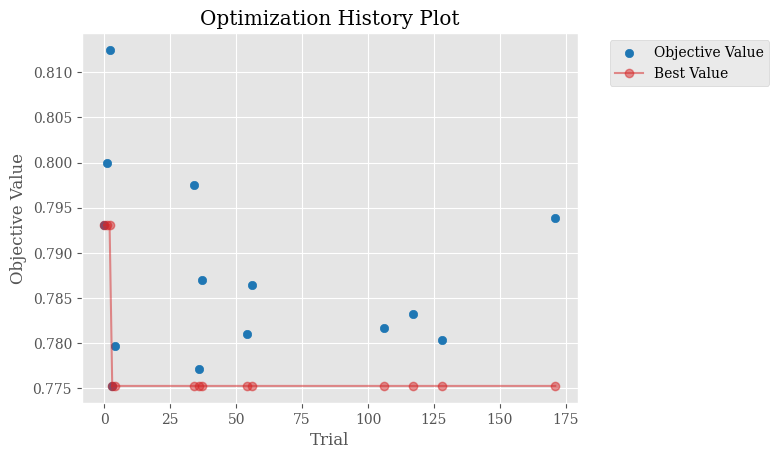

In [ ]:
folder = '/10_lw_dr_al_lr_10_07_23'

df.to_csv(path+'/network_tuning'+folder+folder+' dataframe.csv')

## Optimization History
title = '/optimization_history'
_ = optuna.visualization.matplotlib.plot_optimization_history(study)


plt.savefig(path+'/network_tuning'+folder+title, dpi=250)

<ipython-input-35-07668aa3146b>:3: ExperimentalWarning: plot_intermediate_values is experimental (supported from v2.2.0). The interface can change in the future.
  _ = optuna.visualization.matplotlib.plot_intermediate_values(study2)
<ipython-input-35-07668aa3146b>:4: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


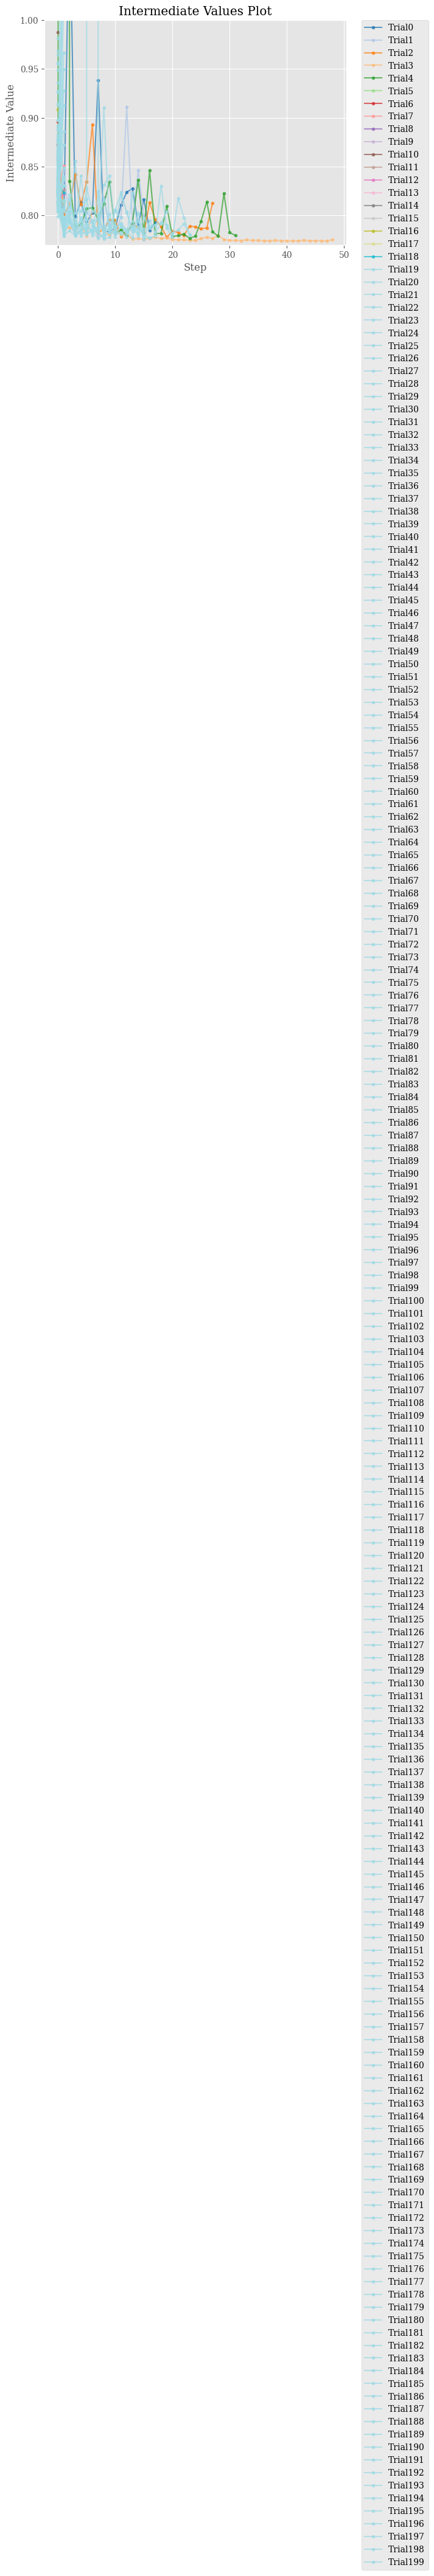

In [ ]:
## Pruning
title = '/pruning'
_ = optuna.visualization.matplotlib.plot_intermediate_values(study)
plt.tight_layout()
plt.ylim(0.77,1)

plt.savefig(path+'/network_tuning'+folder+title, dpi=250)

<ipython-input-36-0d6b4307c4f2>:3: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  _ = optuna.visualization.matplotlib.plot_contour(study2)
[W 2023-07-10 11:32:02,883] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.
<ipython-input-36-0d6b4307c4f2>:4: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


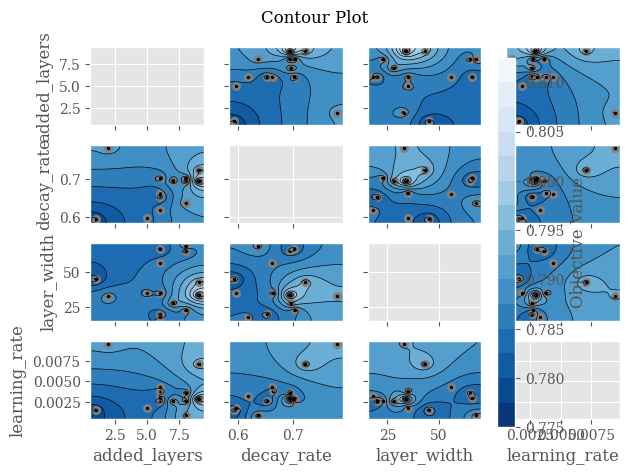

In [ ]:
## Contour
title = '/contour'
_ = optuna.visualization.matplotlib.plot_contour(study)
plt.tight_layout()
plt.savefig(path+'/network_tuning'+folder+title, dpi=250)

<ipython-input-37-82510610d061>:3: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  _ = optuna.visualization.matplotlib.plot_param_importances(study2)


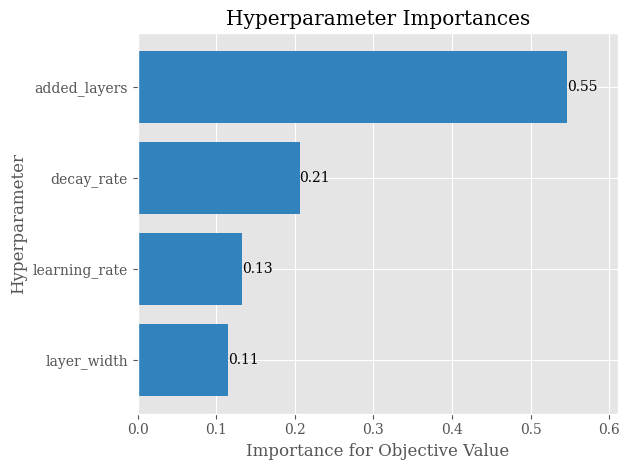

In [ ]:
## Importances
title = '/importance'
_ = optuna.visualization.matplotlib.plot_param_importances(study)
plt.tight_layout()
plt.savefig(path+'/network_tuning'+folder+title, dpi=250)


<ipython-input-38-22e7861d9e63>:3: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  _ = optuna.visualization.matplotlib.plot_slice(study2)


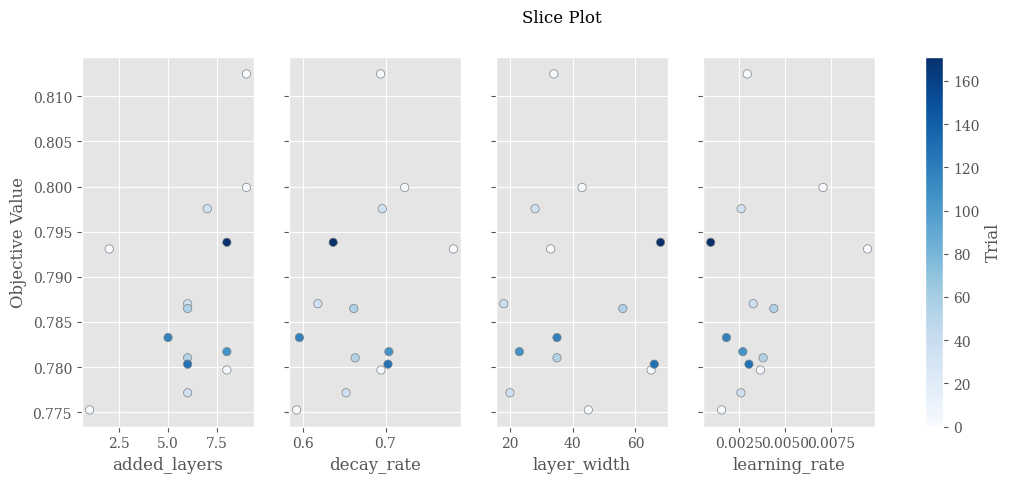

In [ ]:
## plot slice
title = '/plot_slice'
_ = optuna.visualization.matplotlib.plot_slice(study)
# plt.tight_layout()
plt.savefig(path+'/network_tuning'+folder+title, dpi=250)


## Network tuning
Below I have my own set of plots for tuning hyper-parameters. These may become obsolete after using optuna.

In [ ]:
# print the final loss and validation losses
losses, val_losses,stopping = [],[],[]
for i in range(len(histories)):
  losses.append( round(histories[i].history['loss'][-1], 4))
  val_losses.append( round(histories[i].history['val_loss'][-1], 4))
  stopping.append(len(histories[i].history['val_loss']))
  # histories[0].history['loss'][-1]

print('parameter values:\n')
print('losses:\n',losses)
print('val_losses:\n',val_losses)
print('early stopping:\n',stopping)

parameter values:
 [0.0001]
losses:
 [0.7873]
val_losses:
 [0.7839]
early stopping:
 [48]


(0.75, 1.0)

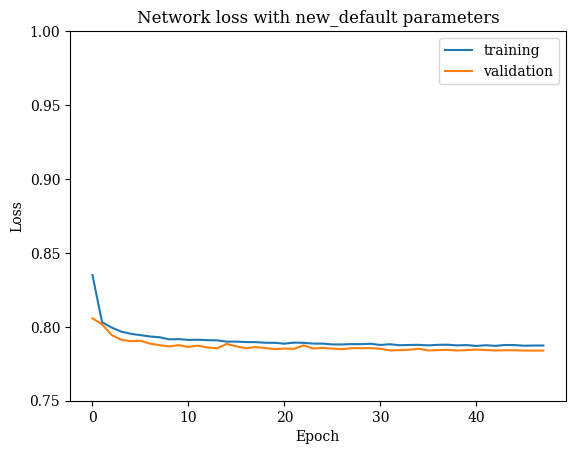

In [ ]:
title = 'new_default'

plt.ylabel('Loss')
plt.xlabel('Epoch')
# plt.title('Network loss with varying '+title+r' ($\theta$)')
plt.title('Network loss with new_default parameters')
for i in range(len(histories)):
    # if i == 1:
    #     continue

    _ = plt.plot(histories[i].history['loss'][:],label=r'training')#; $\theta$='+str(expt_value[i]))
    _ = plt.plot(histories[i].history['val_loss'][:],label=r'validation')#; $\theta$='+str(expt_value[i]))
    # save the history
    # np.save(path+'/network_tuning/'+title+'_'+str(expt_value[i])+'.npy',histories[0].history)
    # np.save(path+'/network_tuning/'+title+'.npy',histories[0].history)
plt.legend()
plt.ylim(0.75,1)
# plt.xlim(0,90)
# plt.savefig(path+'/network_tuning/'+title, dpi=250)


Metric data can be loaded from the numpy file as below

In [ ]:
# note the .item() is important
data = np.load(path+'/network_tuning/batch_size_100.npy',allow_pickle=True).item()
data['val_accuracy'][-1]

0.7307199835777283

## Network Output
The network estimates log K values for the test data. As the ratio of priors is not 1, the network predictions should be transformed to give logK.

In [ ]:
# network output f(xO).
validation_prediction = (model_instances_model[-1].predict(x_test_scaled))

# if using l-POP:
# validation_prediction = leaky_parity_odd_power(validation_prediction)
# validation_prediction = validation_prediction.numpy()

print(validation_prediction)

[[0.31254363]
 [2.7920322 ]
 [1.106809  ]
 ...
 [0.2835028 ]
 [0.56875324]
 [0.4338566 ]]


(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 2.000e+00, 2.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
        3.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 1.000e+00, 2.000e+00,
        0.000e+00, 2.000e+00, 2.000e+00, 4.000e+00, 0.000e+00, 3.000e+00,
        3.000e+00, 3.000e+00, 5.000e+00, 4.000e+00, 1.000e+01, 3.000e+00,
        4.000e+00, 4.000e+00, 7.000e+00, 4.000e+00, 9.000e+00, 4.000e+00,
        1.200e+01, 1.000e+01, 8.000e+00, 8.000e+00, 1.000e+01, 1.500e+01,
        9.000e+00, 5.000e+00, 1.600e+01, 1.900e+01, 1.500e+01, 2.600e+01,
        1.100e+01, 2.700e+01, 2.900e+01, 2.000e+01, 2.800e+01, 2.900e+01,
        3.700e+01, 2.700e+01, 4.400e+01, 5.100e+01, 6.700e+01, 5.800e+01,
        7.800e+01, 7.400e+01, 1.030e+0

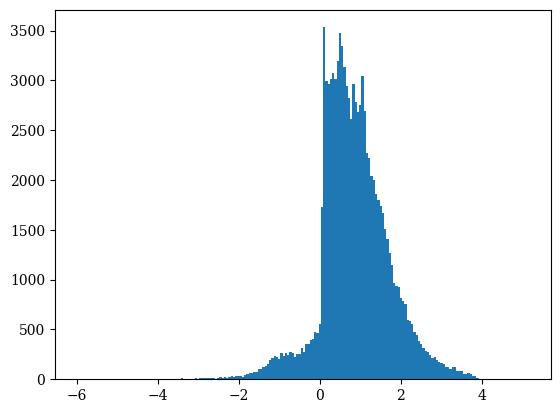

In [ ]:
# plt.hist(validation_prediction,bins=200)
# plt.plot(validation_prediction,'.')
# plt.ylim(-100,100)


# validation_prediction_mean = np.mean(validation_prediction)
# log_K_net = np.log10(np.exp(validation_prediction_mean))
# print(log_K)




# Coverage tests
Here I've tried to recreate the coverage tests using my own code. First we calculate p(M1|x). We then bin the posterior probabilities and examine the fraction of model 1 labels (SIMBA) in each bin.

In [ ]:
# calculate posteriors from network log K values
posterior_model_prob = np.exp(validation_prediction)/(1+np.exp(validation_prediction)) # p(M1|x)
print(posterior_model_prob.shape)

# prepare posterior bins
nbins = 100
probability_array  = np.linspace(0,1,nbins)
# print(probability_array )

(100000, 1)


In [ ]:
def coverage_test(post_model_prob, prob_array):
  '''
  Performs the coverage tests to evaluate calibration of the network
  :param post_model_prob: array of p(M1|x) predicted by network
  :param prob_array: array of chosen bins for posteriors
  :returns: posterior bin centres, validation fractions, post_bin_n (number of data prob in each bin),
            binomial_std (standard error of binomial)
  '''

  # perform coverage test
  bin_centres, fractions, post_bin_n = [],[],[]

  for i in range(0,len(probability_array)-1):
    # bin posteriors
    indexes = np.where((posterior_model_prob > probability_array[i])
                                        & (posterior_model_prob < probability_array[i+1]))[0]
    post_bin = posterior_model_prob[indexes]
    post_bin_mid = float((probability_array[i]+probability_array[i+1]) / 2)
    post_bin_size = float(len(post_bin))

    # get fraction of model 1 labels in each bin
    label_bin = y_test[indexes]
    fraction = np.sum(label_bin) / len(label_bin)

    bin_centres.append(post_bin_mid), fractions.append(fraction), post_bin_n.append(post_bin_size)


  # get the binomial error for each bin
  binomial_std = np.sqrt((np.asarray(bin_centres)*(1.-np.asarray(bin_centres))) / np.asarray(post_bin_n))

  return bin_centres, fractions, post_bin_n, binomial_std


In [ ]:
bin_centres, fractions, post_bin_n, binomial_std = coverage_test(posterior_model_prob, probability_array)

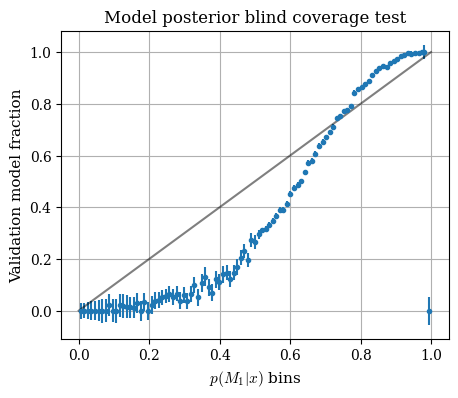

In [ ]:
plt.figure(figsize=(5,4))

# plt.plot(bin_centres, fractions,'.')
# plt.plot(post_bin_means, fractions,'.')
plt.errorbar(post_bin_means, fractions, np.asarray(binomial_std), marker='.', ls='')
plt.title('Model posterior blind coverage test')
plt.xlabel(r'$p(M_1 | x)$ bins', fontsize=11)
plt.ylabel(str('Validation model fraction'), fontsize=11)
plt.plot([0,1],[0,1],'k-',alpha=0.5)
# plt.axis('square')
plt.grid(True)

plt.savefig(path+'coverage_test_20_B.png', dpi=250)
# plt.axis('equal')

## Residual between model fraction and posterior probability from evidence network

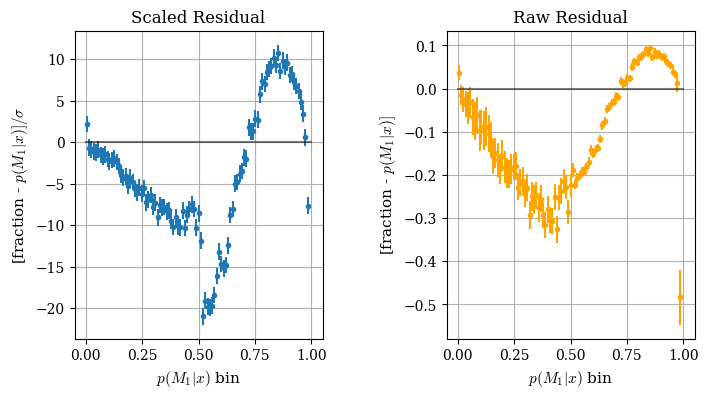

In [ ]:
residual = (np.asarray(fractions) - np.asarray(post_bin_means))/np.asarray(binomial_std)

plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
# plt.plot(post_bin_means, residual, marker='.', ls='')
plt.errorbar(post_bin_means, residual,yerr=binomial_std/np.asarray(binomial_std), marker='.', ls='')
# plt.plot(post_bin_means, residual*binomial_std, marker='.', ls='',c='orange')
plt.title('Scaled Residual')
plt.xlabel(r'$p(M_1 | x)$ bin', fontsize=11)
plt.ylabel(r'[fraction - $p(M_1 | x) ] / \sigma$', fontsize=11)
plt.plot([0,1],[0,0],'k-',alpha=0.5)
# plt.axis('square')
plt.grid(True)

plt.subplot(1,2,2)
# plt.plot(post_bin_means, residual, marker='.', ls='')
plt.errorbar(post_bin_means, residual*binomial_std,yerr=binomial_std, marker='.', ls='',c='orange')
plt.title('Raw Residual')
plt.xlabel(r'$p(M_1 | x)$ bin', fontsize=11)
plt.ylabel(r'[fraction - $p(M_1 | x) ] $', fontsize=11)
plt.plot([0,1],[0,0],'k-',alpha=0.5)
# plt.axis('square')
plt.grid(True)

plt.subplots_adjust(wspace=.5)
